In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html(index=False).replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# Customer Insights Analytics, Pareto and Recency, Frequency and Monetary Value Analysis/Segmentation:

In [2]:
!ls

Customers Insights & RFM Analysis.png e-commerce_data.csv
customer_insights.ipynb


## 1. Cleaning, Exploration and Visualisation:

In [3]:
df = pd.read_csv('e-commerce_data.csv',encoding = "ISO-8859-1")
print('rows:',df.shape[0],'columns:',df.shape[1])

df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df['CustomerID'] = df['CustomerID'].fillna(0).astype(int).astype(str).replace('0',np.nan)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['day'] = [i.day for i in df['InvoiceDate']]  
df['day_name'] = [i.day_name() for i in df['InvoiceDate']]  
df['day_of_year'] = [i.dayofyear for i in df['InvoiceDate']]  
df['week'] = [i.weekofyear for i in df['InvoiceDate']]  
df['hour'] = [i.hour for i in df['InvoiceDate']]  
df['month'] = [i.month for i in df['InvoiceDate']]
df['year'] = [i.year for i in df['InvoiceDate']]
df['weekday'] = [i.isoweekday() for i in df['InvoiceDate']]
df['weekend'] = [0 if x <= 5 else 1 for x in df['weekday']]

df['month_year'] = df['year'].map(str)+ '-' +df['month'].map(str)
df['month_year'] = pd.to_datetime(df['month_year'], format='%Y-%m').dt.strftime('%Y-%m')

df.head(3)

rows: 541909 columns: 8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,day,day_name,day_of_year,week,hour,month,year,weekday,weekend,month_year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1,Wednesday,335,48,8,12,2010,3,0,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,Wednesday,335,48,8,12,2010,3,0,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,1,Wednesday,335,48,8,12,2010,3,0,2010-12


In [4]:
for i in df.columns:
    if df[i].dtype == object:
        print('{:12} - Unique count: {:6}, {}'.format(i,len(df[i].unique()),df[i].unique()[:2]))
    else:
        try:
            print('{:12} - min: {:10}, mean: {:7}, median: {:7}, max: {:7}'.format(i,df[i].min(),df[i].mean(),df[i].median(),df[i].max()))
        except Exception:
            pass

InvoiceNo    - Unique count:  25900, ['536365' '536366']
StockCode    - Unique count:   4070, ['85123A' '71053']
Description  - Unique count:   4224, ['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN']
Quantity     - min:     -80995, mean: 9.55224954743324, median:     3.0, max:   80995
UnitPrice    - min:  -11062.06, mean: 4.611113626088513, median:    2.08, max: 38970.0
CustomerID   - Unique count:   4373, ['17850' '13047']
Country      - Unique count:     38, ['United Kingdom' 'France']
TotalPrice   - min:  -168469.6, mean: 17.98779487699964, median:    9.75, max: 168469.6
day          - min:          1, mean: 15.023096128685813, median:    15.0, max:      31
day_name     - Unique count:      6, ['Wednesday' 'Thursday']
day_of_year  - min:          4, mean: 213.61300882620515, median:   237.0, max:     357
week         - min:          1, mean: 30.729048604101425, median:    34.0, max:      51
hour         - min:          6, mean: 13.078729085510666, median:    13.0, max:   

In [5]:
df.isnull().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
TotalPrice     False
day            False
day_name       False
day_of_year    False
week           False
hour           False
month          False
year           False
weekday        False
weekend        False
month_year     False
dtype: bool

### Columns 'Description' and 'CustomerID' have missing values:

- 'Description' feature not only have empty descriptions but also incorrect ones (same stockcode with different descriptions), so instead of just dropping them we will map them back based on their relation 'StockCode' to 'Description'.

- 'CustomerID' feature has 3710 invoice with no CustomerID which represents 135 thousand lines, I will not filter them out but give them new and individual CustomerIDs assuming they are seperate customers. If we had better data we could surely do something better.

#### Treatment of the 'Description' column:

In [6]:
# ## checking the 'Description' column:
# df[(df['StockCode'] == '22139')].head(50)

In [7]:
df['StockCode'] = df['StockCode'].str.upper()

## description that comes back the most per 'StockCode'  =. if list comes back, choose first element.
stockCode = df.groupby(['StockCode'])['Description'].agg(lambda x: x.mode(dropna=False).iloc[0]).to_frame().rename(columns={'Description':'Description2'}) #.agg(pd.Series.mode).rename('Description2')

print(len(df[df['Description'].isnull()]))
df = df.merge(stockCode,how='left',left_on='StockCode',right_on='StockCode').drop('Description',axis=1).rename(columns={'Description2':'Description'})
df['Description'] = df['Description'].astype(str).apply(lambda x: np.nan if len(x)==0 else x)
print(len(df[df['Description'].isnull()]))
df.head(3)

1454
0


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,day,day_name,day_of_year,week,hour,month,year,weekday,weekend,month_year,Description
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1,Wednesday,335,48,8,12,2010,3,0,2010-12,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,Wednesday,335,48,8,12,2010,3,0,2010-12,WHITE METAL LANTERN
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,1,Wednesday,335,48,8,12,2010,3,0,2010-12,CREAM CUPID HEARTS COAT HANGER


#### Treatment of the 'CustomerID' column:

In [8]:
# ## checking the 'CustomerID' column:
# df[(df['CustomerID'].isnull())].head(50)
len(df[(df['CustomerID'].isnull())]['InvoiceNo'].unique())

3710

In [9]:
# ## filter them out.
# df = df[~(df['CustomerID'].isnull())]

In [10]:
listy = df[(df['CustomerID'].isnull())]['InvoiceNo'].unique()

dicco_unknown_customer = {}
for i in range(len(listy)):
    dicco_unknown_customer[listy[i]] = 'cust_{}'.format(i)
    
df['CustomerID'] = [x if x is not np.nan else dicco_unknown_customer[y] for x,y in zip(df['CustomerID'],df['InvoiceNo'])] 
print(len(df[df['CustomerID'].isnull()]))

0


### Now I personally like to look and delve into all aspects of the dataset to see to which extend we can exploit it.

What do we want to know about this dataset and more specifically about these customers?

- checking distributions (and log distribution)
- how often customer order (groupby first to get ride of credit lines)
- top 5 product descriptions, customers, countries, etc...
- frequency of order, when was the first and the last order (how long ago)
- etc...

In [11]:
df_desc = df.describe(include='all').T
df_desc.drop(['top','first','last'],axis=1).fillna("")

,count,unique,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909.0,25900,1114,,,,,,,
StockCode,541909.0,3958,2380,,,,,,,
Quantity,541909.0,,,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909.0,23260,1114,,,,,,,
UnitPrice,541909.0,,,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,541909.0,8082,7983,,,,,,,
Country,541909.0,38,495478,,,,,,,
TotalPrice,541909.0,,,17.9878,378.811,-168470,3.4,9.75,17.4,168470
day,541909.0,,,15.0231,8.66406,1,7,15,22,31
day_name,541909.0,6,103857,,,,,,,


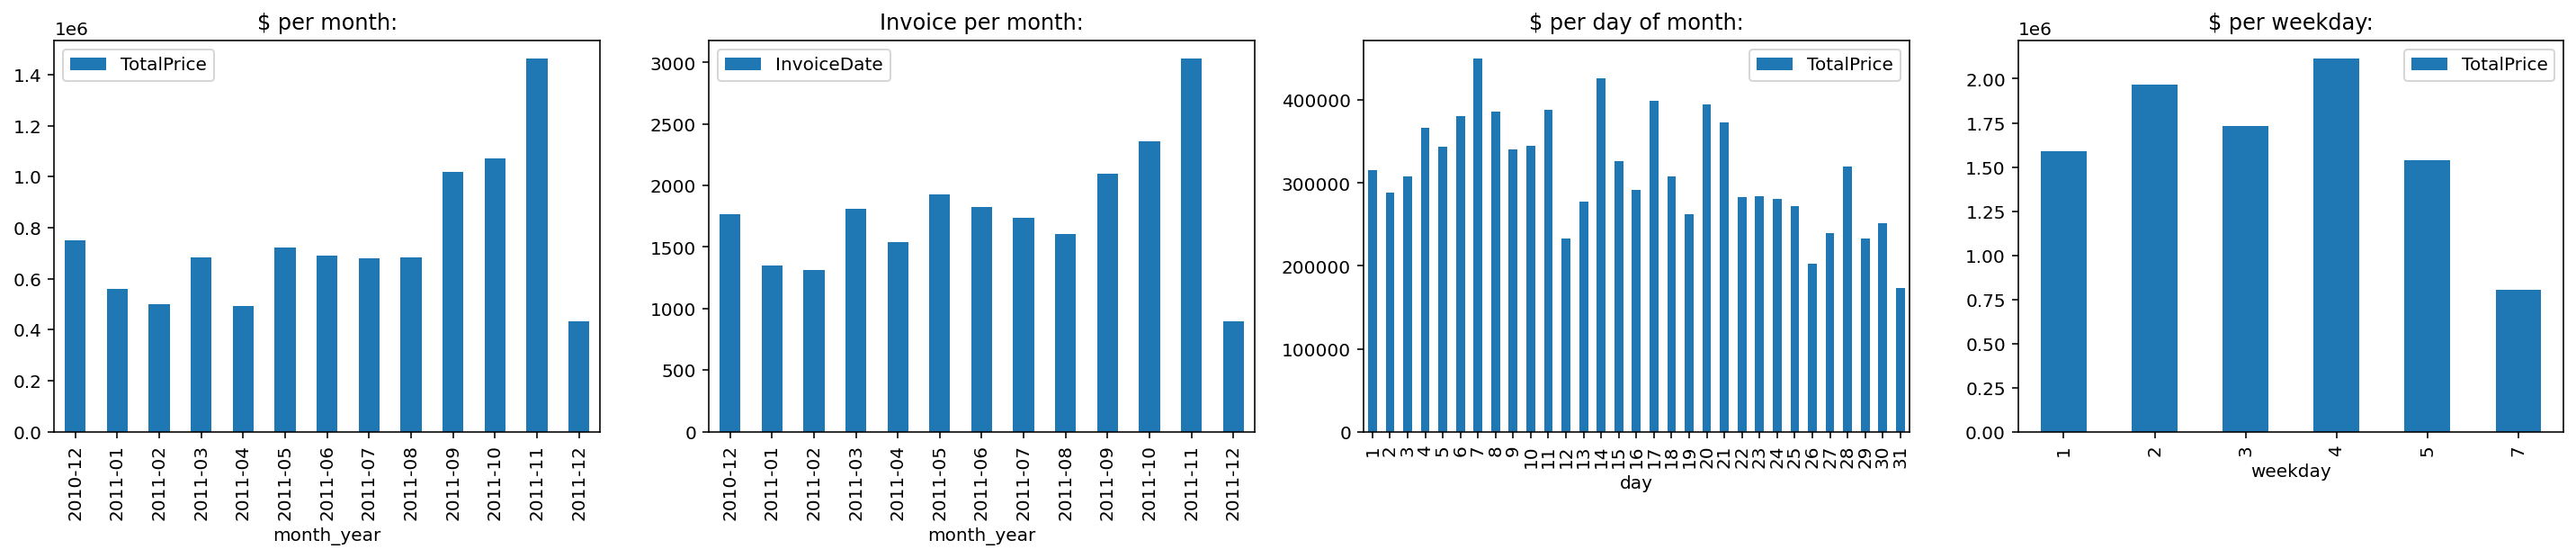

In [12]:
fig,ax=plt.subplots(1,4,figsize=(25,4))

df.groupby(["month_year"]).agg({'TotalPrice':np.sum}).plot(kind="bar",ax=ax[0]);
ax[0].set_title('$ per month:');

df.groupby(["month_year"]).agg({"InvoiceDate":pd.Series.nunique}).plot(kind="bar",ax=ax[1]);
ax[1].set_title('Invoice per month:');

df.groupby(["day"]).agg({'TotalPrice':np.sum}).plot(kind="bar",ax=ax[2]);
ax[2].set_title('$ per day of month:');

df.groupby(["weekday"]).agg({'TotalPrice':np.sum}).plot(kind="bar",ax=ax[3]);
ax[3].set_title('$ per weekday:');

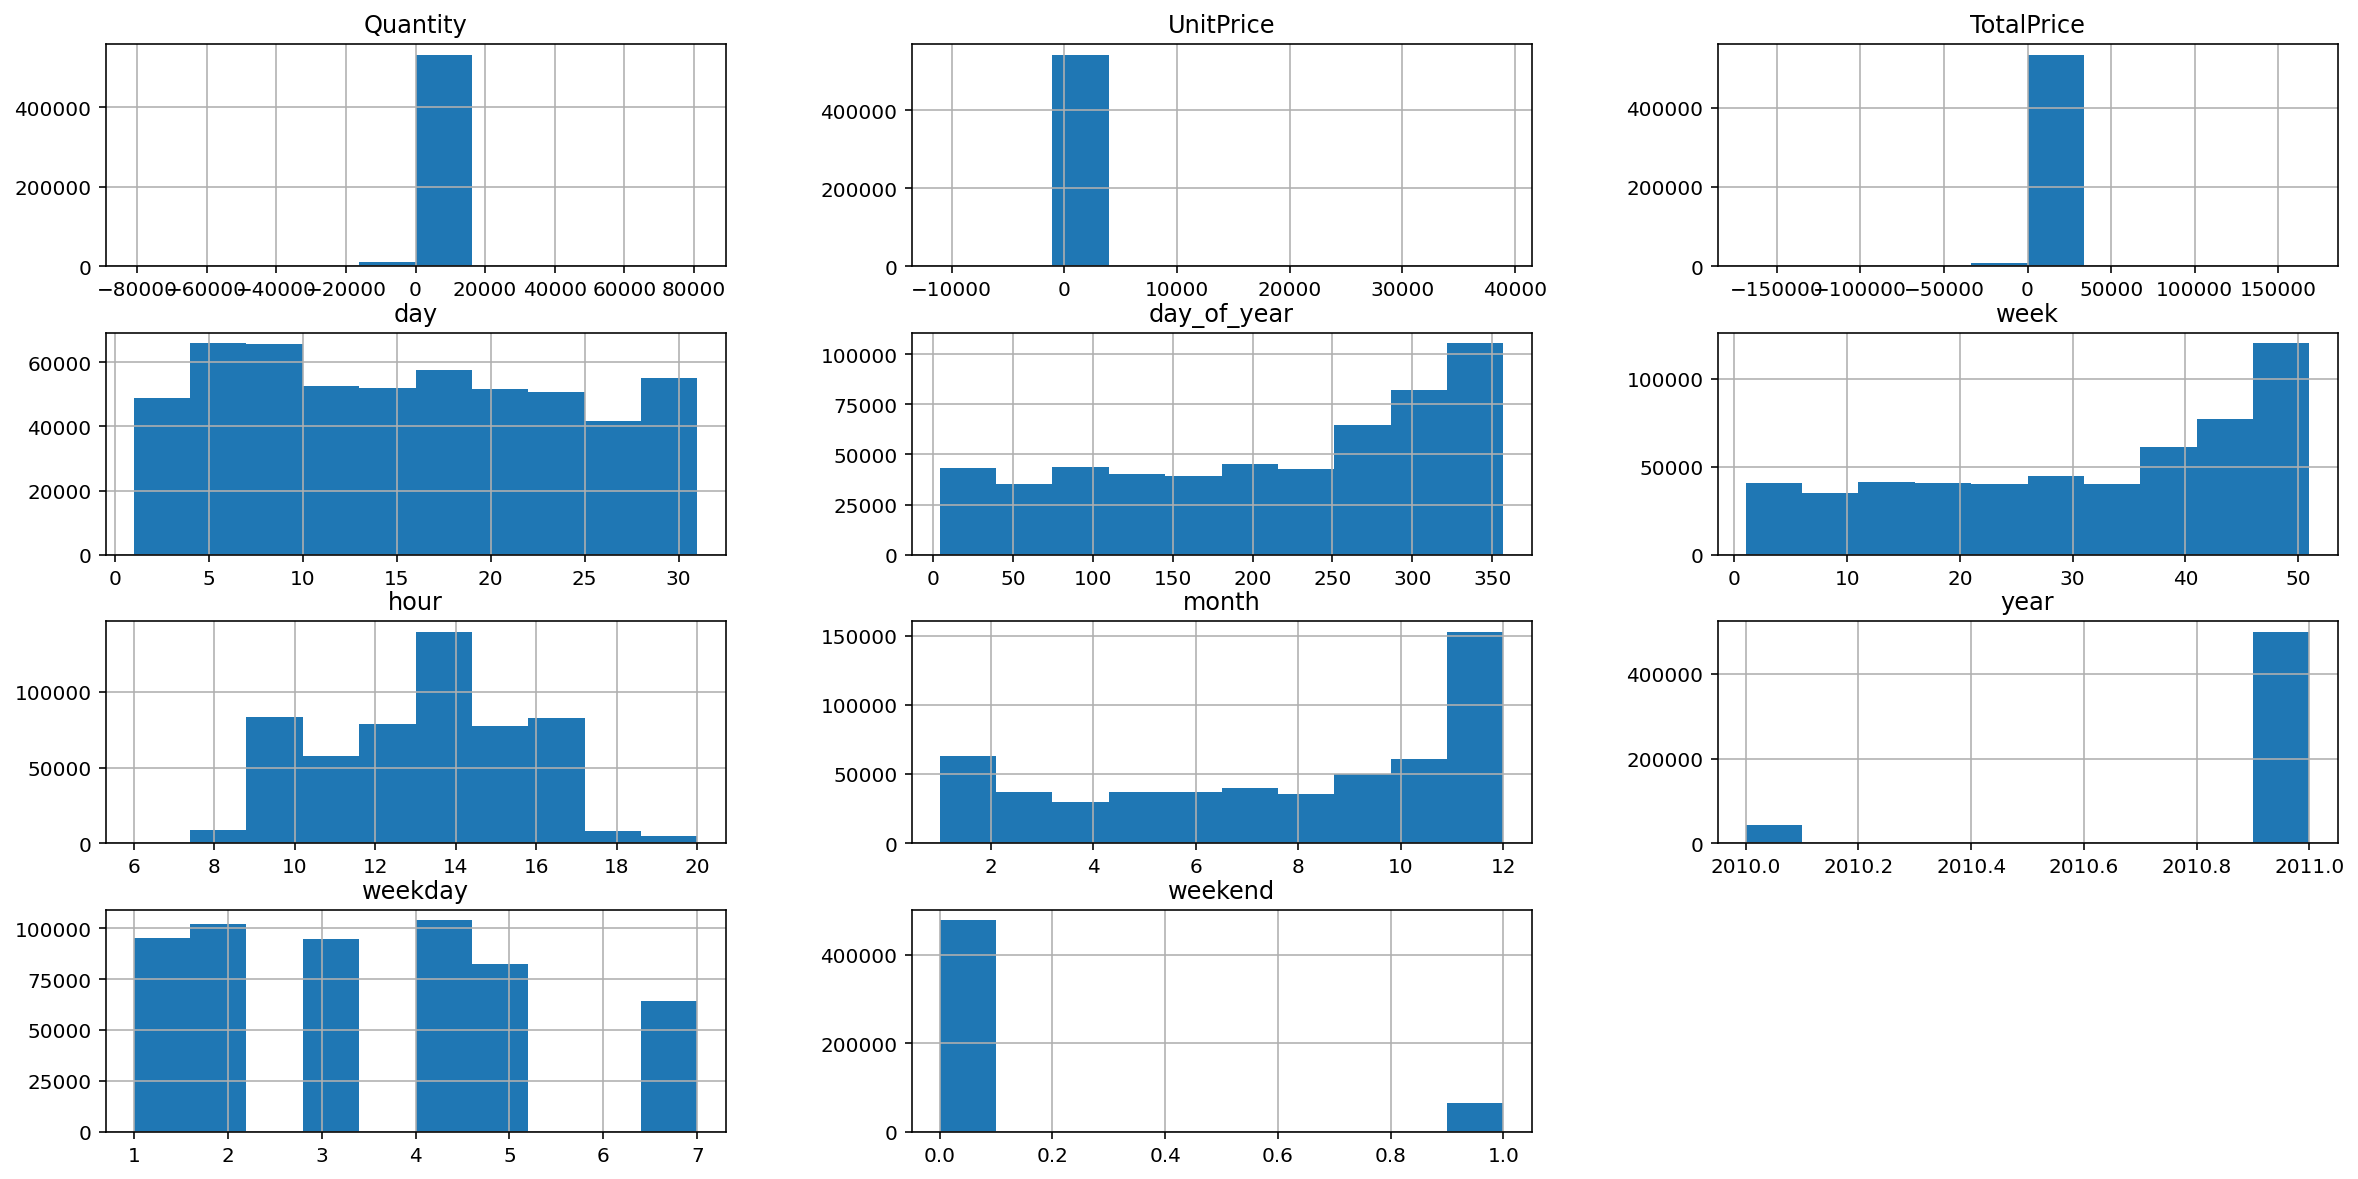

In [13]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df.hist(ax=ax);

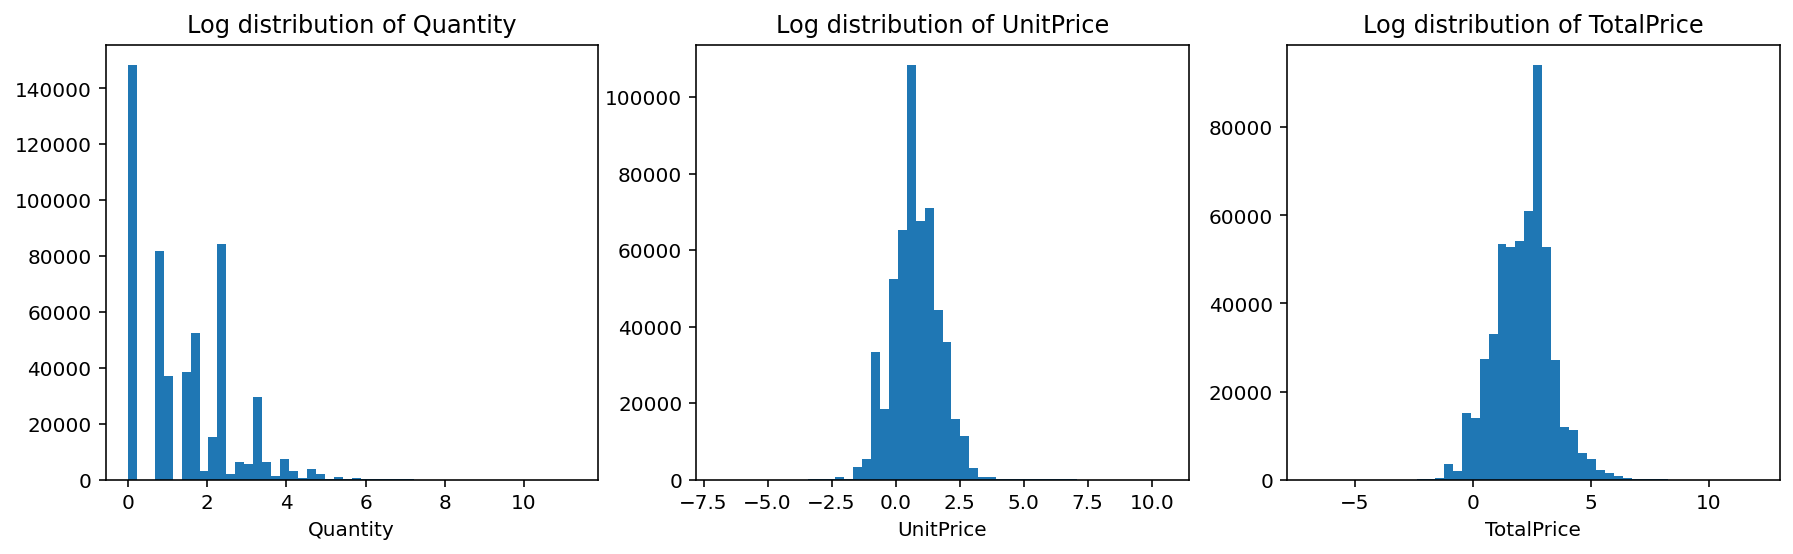

In [14]:
fig,ax=plt.subplots(1,3,figsize=(15,4))

listy = ['Quantity','UnitPrice','TotalPrice']

for i in range(len(listy)):
        df1 = pd.DataFrame()
        df1['log_{}'.format(listy[i])] = np.log(df[listy[i]])
        ax[i].hist(df1[np.isfinite(df1['log_{}'.format(listy[i])])]['log_{}'.format(listy[i])].values,bins=50)
        ax[i].set_xlabel(listy[i])
        ax[i].set_title('Log distribution of {}'.format(listy[i]))

### Pareto chart and 80-20 rule:

#### The 80/20 rule states that for many events roughly 80% of the effects come from 20% of the causes.

Let's check here if 80% of revenue are generated by 20% of our customers:

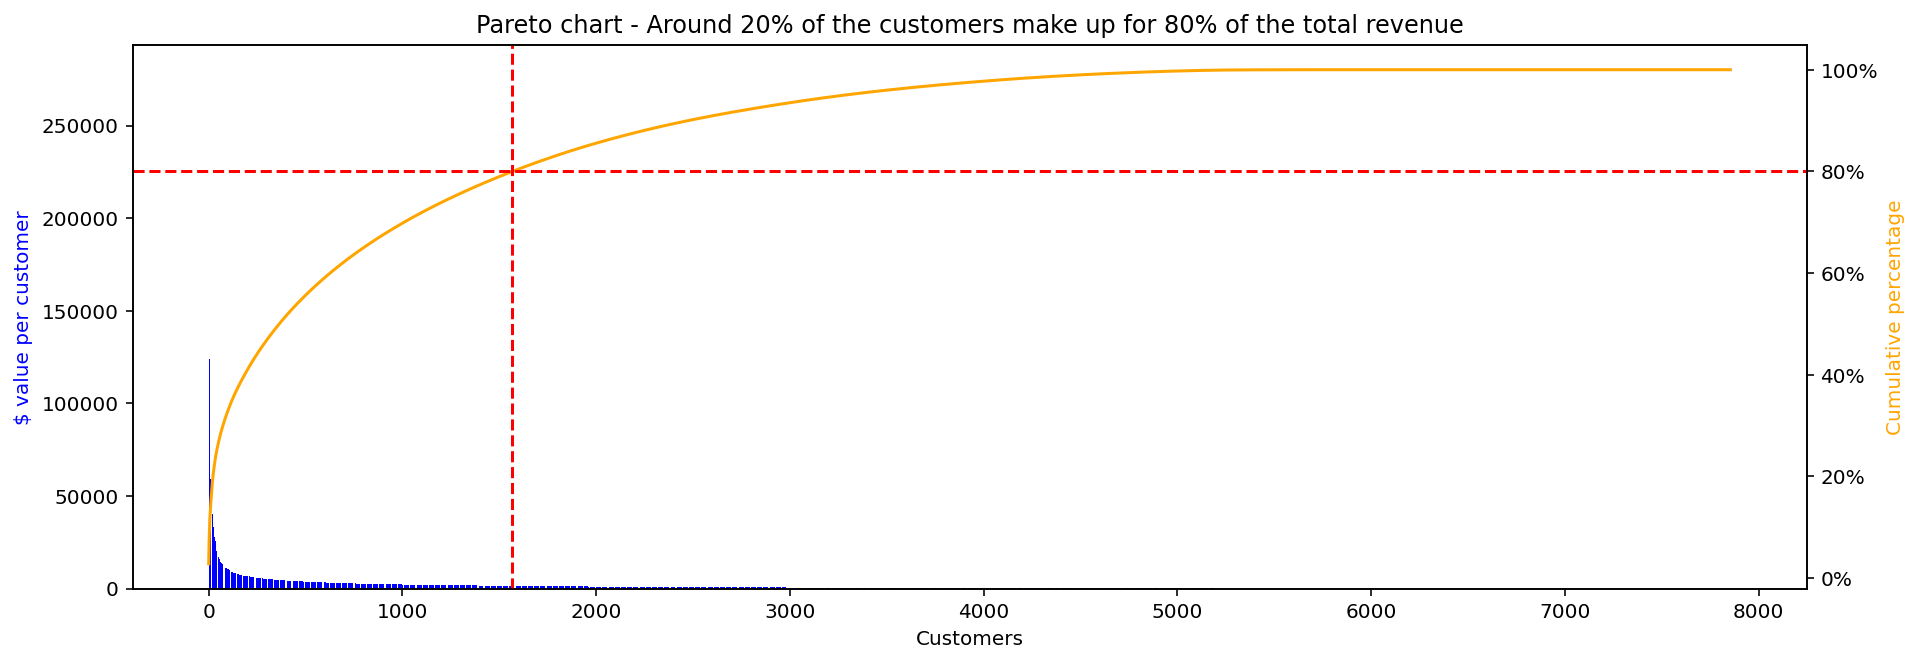

In [25]:
desc_price = df.groupby(['CustomerID']).agg({'TotalPrice':np.sum}).reset_index().sort_values('TotalPrice',ascending=False)
desc_price = desc_price[desc_price['TotalPrice'] >= 0]
desc_price['cumulative_sum'] = desc_price['TotalPrice'].cumsum()
desc_price['cumulative_pct'] = desc_price['cumulative_sum']/desc_price['TotalPrice'].sum()*100
desc_price = desc_price.reset_index(drop=True)


value_closest_to_80 = desc_price.iloc[(desc_price['cumulative_pct']-80).abs().argsort()[:1]].index[0]

import matplotlib.ticker as mtick

fig,ax=plt.subplots(figsize=(15,5))

ax.set_title('Pareto chart - Around {}% of the customers make up for 80% of the total revenue'.format(round(value_closest_to_80/len(desc_price)*100)))

ax2 = ax.twinx()

ax.bar(desc_price.index,desc_price['TotalPrice'],color='blue');
ax.set_xlabel('Customers')
ax.set_ylabel('$ value per customer',color='blue')

ax2.plot(desc_price.index,desc_price['cumulative_pct'],color='orange');
ax2.set_ylabel('Cumulative percentage',color='orange')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2.axhline(y=80, color='r', linestyle='--');
ax2.axvline(x=value_closest_to_80, color='r', linestyle='--');

### Top 5 Items ordered (dollar value wise) and their trend, what can you deduce from this?

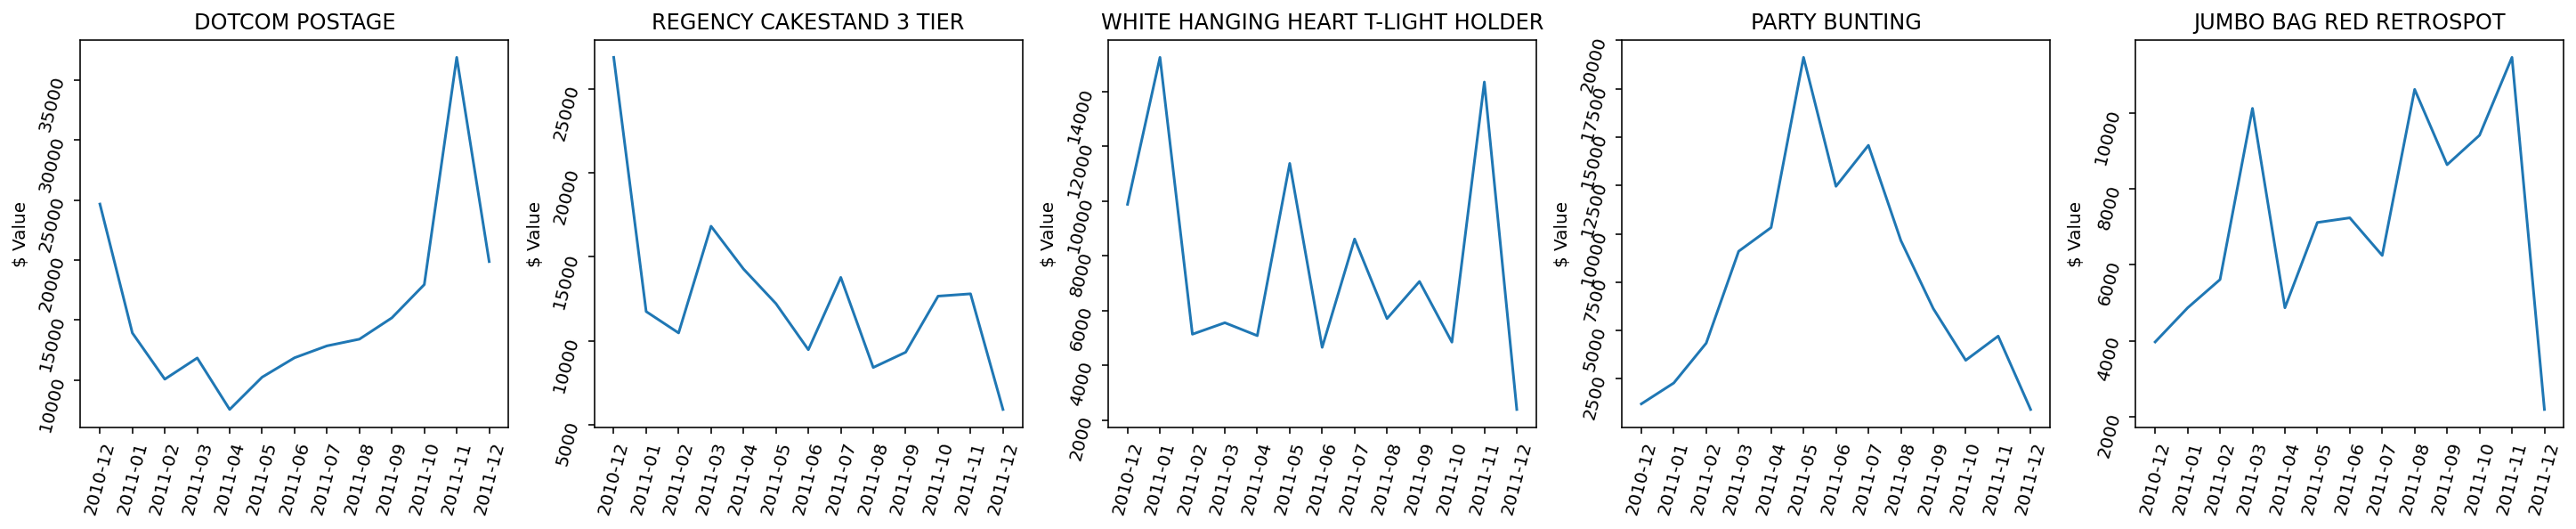

In [16]:
description = df.groupby(['Description']).agg({'TotalPrice':np.sum}).reset_index().sort_values('TotalPrice',ascending=False).head(5)

dfT = df[df['Description'].isin(description['Description'].unique())]
dfT = dfT.groupby(['month_year','Description']).agg({'TotalPrice':np.sum}).reset_index()

listo = description['Description'].unique()

fig,ax=plt.subplots(1,len(listo),figsize=(25,4))

for i in range(len(listo)):
    dfW = dfT[dfT['Description'] == listo[i]]
    ax[i].plot(dfW['month_year'],dfW['TotalPrice'],label=listo[i])
    ax[i].tick_params(labelrotation=75)
    ax[i].set_ylabel('$ Value')
    ax[i].set_title(listo[i])

In [17]:
country = df.groupby(['Country']).agg({'CustomerID':pd.Series.nunique}).reset_index().sort_values('CustomerID',ascending=False)

desc_quant = df.groupby(['Description']).agg({'CustomerID':pd.Series.nunique}).reset_index().sort_values('CustomerID',ascending=False)

desc_price = df.groupby(['Description']).agg({'TotalPrice':np.sum}).reset_index().sort_values('TotalPrice',ascending=False)

invoice = df.groupby(['CustomerID']).agg({'InvoiceNo':pd.Series.nunique}).reset_index().sort_values('InvoiceNo',ascending=False).rename(columns={'InvoiceNo':'NumInvoice'})

quantity = df.groupby(['CustomerID']).agg({'Quantity':np.sum}).reset_index().sort_values('Quantity',ascending=False).rename(columns={'Quantity':'TotalQuantity'})

amount = df.groupby(['CustomerID']).agg({'TotalPrice':np.sum}).reset_index().sort_values('TotalPrice',ascending=False)


display_side_by_side(country.head(), desc_quant.head(),desc_price.head(),invoice.head(),quantity.head(),amount.head(),
                     titles=['Top 5 Country with most Customers','Top 5 items ordered the most','Top 5 categories $ value wise','Top 5 Customers with most invoices',
                             'Top 5 Customers with most quantities','Top 5 Customers with most $value spent'])

Country,CustomerID
United Kingdom,7587
Germany,95
France,90
EIRE,44
Spain,31
Description,CustomerID
REGENCY CAKESTAND 3 TIER,1175
WHITE HANGING HEART T-LIGHT HOLDER,1151
JUMBO BAG RED RETROSPOT,1128
PARTY BUNTING,1015


### Let's look at the number of days between first and last invoices, the number of days since their first order, and the days since last purchase:

CustomerID,DaysBetweenFirstLastInv
15311,374.0
12662,373.0
17924,373.0
16210,373.0
13777,373.0
CustomerID,days_as_customer
12838,374.0
12748,374.0
13747,374.0
13748,374.0


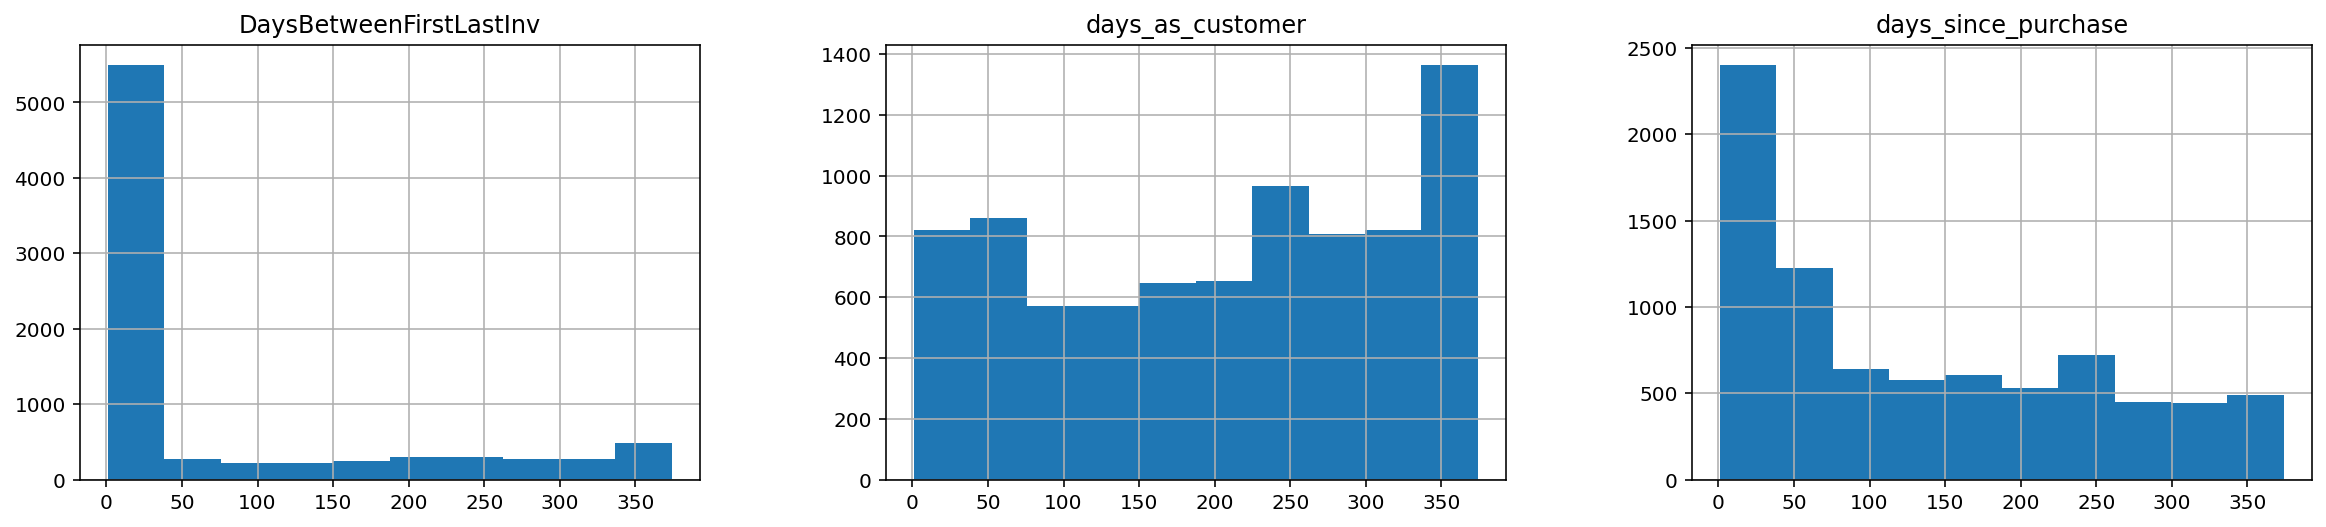

In [18]:
## DaysBetweenFirstLastInv
df1 = df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].min()
df1.columns = ['CustomerID', 'FirstInvoice']

df2 = df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
df2.columns = ['CustomerID', 'LastInvoice']

df1 = df1.merge(df2,how='left', left_on='CustomerID', right_on='CustomerID')
df1['DaysBetweenFirstLastInv'] = 1 + (df1['LastInvoice']-df1['FirstInvoice']).astype('timedelta64[D]')
df1 = df1.drop(['FirstInvoice','LastInvoice'],axis=1).sort_values('DaysBetweenFirstLastInv', ascending=False)

## days_as_customer
df3 = df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].min()
df3.columns = ['CustomerID', 'FirstInvoice']
df3['lastDate'] = df['InvoiceDate'].max()
df3['days_as_customer'] = 1 + (df3['lastDate']-df3['FirstInvoice']).astype('timedelta64[D]')
df3 = df3.drop(['lastDate','FirstInvoice'], axis=1).sort_values('days_as_customer', ascending=False)

## days_since_purchase
df4 = df.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
df4.columns = ['CustomerID', 'lastInvoice']
df4['lastDate'] = df['InvoiceDate'].max()
df4['days_since_purchase'] = 1 + (df4['lastDate']-df4['lastInvoice']).astype('timedelta64[D]')
df4 = df4.drop(['lastDate','lastInvoice'], axis=1).sort_values('days_since_purchase', ascending=False)

display_side_by_side(df1.head(), df3.head(),df4.head(),
                     titles=['Top 5 Customers DaysBetweenFirstLastInv','Top 5 Customers days_as_customer','Top 5 Customers days_since_purchase'])

fig,ax=plt.subplots(1,3,figsize=(20,4))
df1.hist(ax=ax[0])
df3.hist(ax=ax[1])
df4.hist(ax=ax[2]);

Count of invoices per Customers 
 
 
 daysBins 
 (0, 5] invoices 
 (5, 50] invoices 
 (50, 250] invoices 
 
 
 
 
 (0, 100] days 
 2094.0 
 33.0 
 NaN 
 
 
 (100, 200] days 
 1471.0 
 60.0 
 NaN 
 
 
 (200, 375] days 
 3436.0 
 964.0 
 24.0 
 
 
 Value spent per Customers 
 
 
 daysBins 
 $ (0.0, 100.0] 
 $ (100.0, 1000.0] 
 $ (1000.0, 10000.0] 
 $ (10000.0, 28000.0] 
 
 
 
 
 (0, 100] days 
 208 
 829 
 315 
 2 
 
 
 (100, 200] days 
 160 
 573 
 289 
 3 
 
 
 (200, 375] days 
 342 
 1486 
 1439 
 74 
 
 
 Count of invoices and value spent per Customers 
 
 
 countBins 
 $ (0.0, 100.0] 
 $ (100.0, 1000.0] 
 $ (1000.0, 10000.0] 
 $ (10000.0, 28000.0] 
 
 
 
 
 (0, 5] invoices 
 709.0 
 2793.0 
 1153.0 
 13.0 
 
 
 (5, 50] invoices 
 1.0 
 95.0 
 888.0 
 60.0 
 
 
 (50, 250] invoices 
 NaN 
 NaN 
 2.0 
 6.0

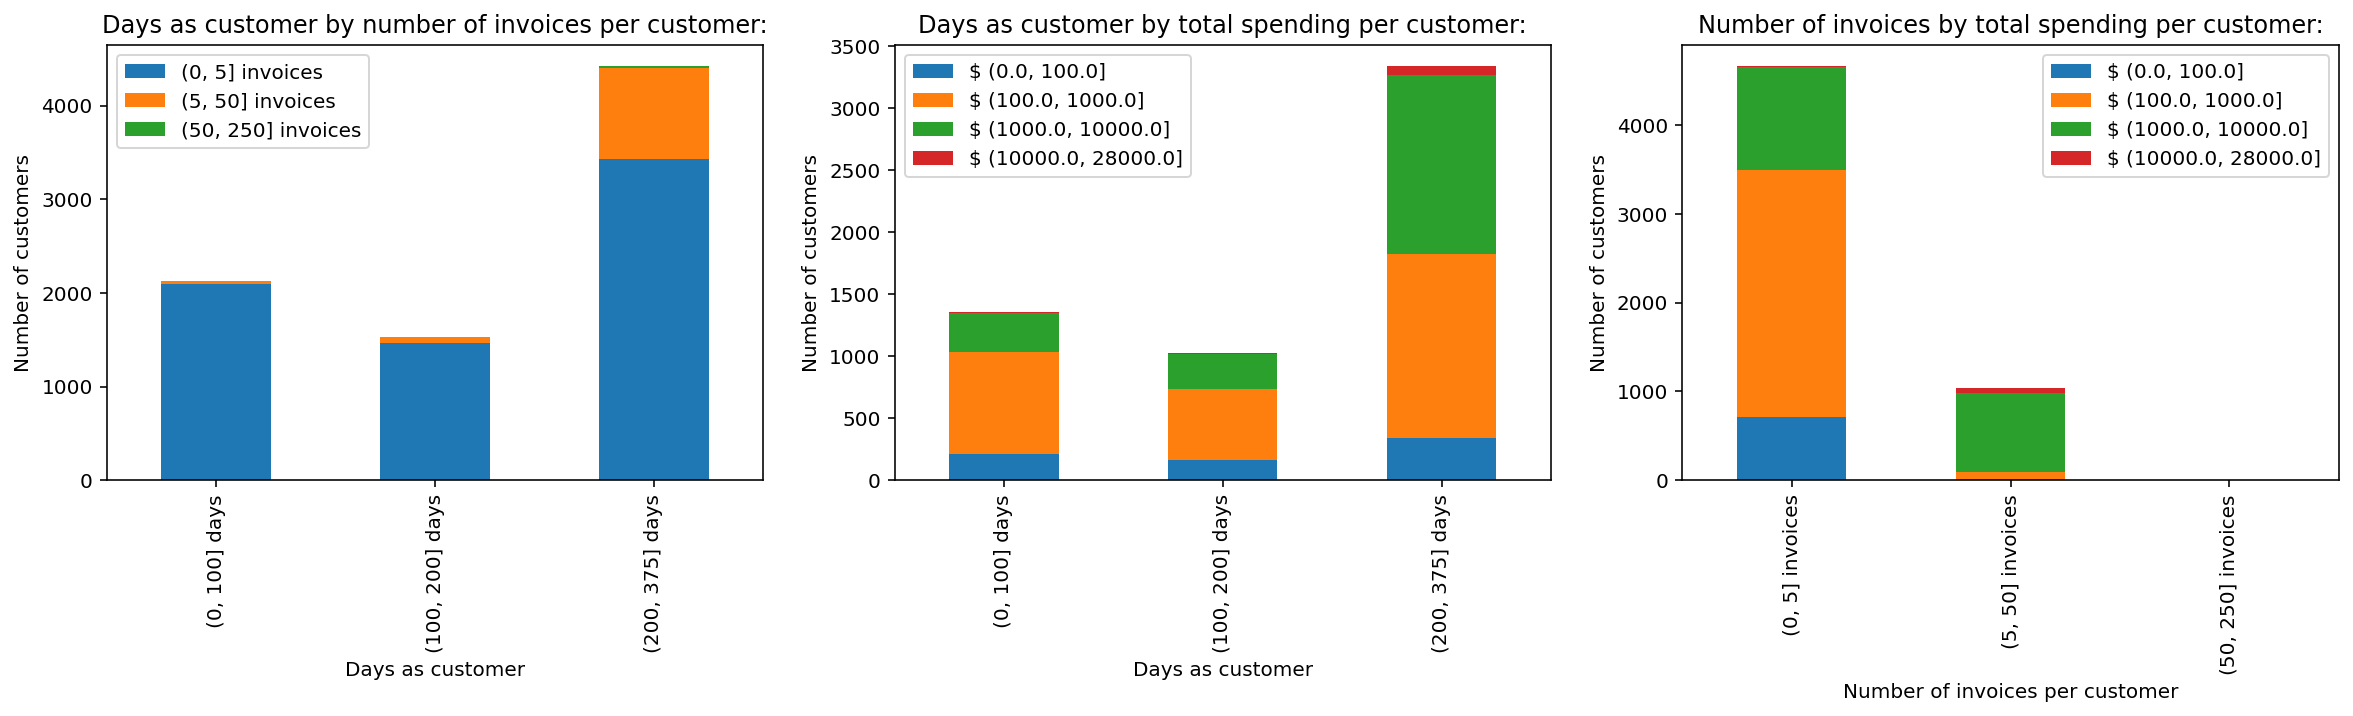

In [19]:
##### COUNT INVOICES #####
df3 = df.groupby(['CustomerID']).agg({'InvoiceDate':[min,pd.Series.nunique]}).reset_index()
df3.columns = ['CustomerID', 'FirstInvoice','CountInvoice']
df3['now'] = df['InvoiceDate'].max()
df3['days_as_customer'] = 1 + (df3['now']-df3['FirstInvoice']).astype('timedelta64[D]')
df3 = df3.drop(['now','FirstInvoice'], axis=1).sort_values('days_as_customer', ascending=False)
 
bins = [0, 5, 50, 250]
df3['countBins'] = pd.cut(df3['CountInvoice'], bins).astype(str) + " invoices"

bins = [0, 100, 200, 375]
df3['daysBins'] = pd.cut(df3['days_as_customer'], bins).astype(str) + " days"

df3 = pd.DataFrame(df3.pivot_table(index='daysBins',columns='countBins',values='CustomerID',aggfunc=pd.Series.nunique).to_records())
#########################

##### $ VALUE #####
df6 = df.groupby(['CustomerID']).agg({'InvoiceDate':min,'TotalPrice':np.sum}).reset_index()
df6.columns = ['CustomerID', 'FirstInvoice','TotalAmount']
df6['now'] = df['InvoiceDate'].max()
df6['days_as_customer'] = 1 + (df6['now']-df6['FirstInvoice']).astype('timedelta64[D]')
df6 = df6.drop(['now','FirstInvoice'], axis=1).sort_values('days_as_customer', ascending=False)
 
bins = [0, 100, 1000, 10000, 28000]
df6['amountBins'] = '$ ' + pd.cut(df6['TotalAmount'], bins).astype(str)
df6 = df6[df6['amountBins'] != '$ nan']

bins = [0, 100, 200, 375]
df6['daysBins'] = pd.cut(df6['days_as_customer'], bins).astype(str) + " days"

df6 = pd.DataFrame(df6.pivot_table(index='daysBins',columns='amountBins',values='CustomerID',aggfunc=pd.Series.nunique).to_records())
#########################


##### COUNT INVOICES & AMOUNT #####
df7 = df.groupby(['CustomerID']).agg({'InvoiceDate':[min,pd.Series.nunique],'TotalPrice':np.sum}).reset_index()
df7.columns = ['CustomerID', 'FirstInvoice','CountInvoice','TotalAmount']
df7['now'] = df['InvoiceDate'].max()
df7['days_as_customer'] = 1 + (df7['now']-df7['FirstInvoice']).astype('timedelta64[D]')
df7 = df7.drop(['now','FirstInvoice'], axis=1).sort_values('days_as_customer', ascending=False)
 
bins = [0, 5, 50, 250]
df7['countBins'] = pd.cut(df7['CountInvoice'], bins).astype(str) + " invoices"

bins = [0, 100, 200, 375]
df7['daysBins'] = pd.cut(df7['days_as_customer'], bins).astype(str) + " days"

bins = [0, 100, 1000, 10000, 28000]
df7['amountBins'] = "$ " + pd.cut(df7['TotalAmount'], bins).astype(str)
df7 = df7[df7['amountBins'] != '$ nan']
# 'daysBins',
df7 = pd.DataFrame(df7.pivot_table(index='countBins',columns='amountBins',values='CustomerID',aggfunc=pd.Series.nunique).to_records())

##################################


display_side_by_side(df3.head(10),df6.head(10),df7.head(10),titles=['Count of invoices per Customers','Value spent per Customers','Count of invoices and value spent per Customers'])


##### PLOTTING #####
fig,ax=plt.subplots(1,3,figsize=(20,4))

df3.plot.bar(stacked=True,ax=ax[0])
ax[0].set_xticks([x for x in range(len(df3['daysBins']))])
ax[0].set_xticklabels(df3['daysBins'])

ax[0].set_title("Days as customer by number of invoices per customer:")
ax[0].set_xlabel('Days as customer')
ax[0].set_ylabel('Number of customers');

df6.plot.bar(stacked=True, ax=ax[1])
ax[1].set_xticks([x for x in range(len(df6['daysBins']))])
ax[1].set_xticklabels(df6['daysBins'])

ax[1].set_title("Days as customer by total spending per customer:")
ax[1].set_xlabel('Days as customer')
ax[1].set_ylabel('Number of customers');

df7.plot.bar(stacked=True, ax=ax[2])
ax[2].set_xticks([x for x in range(len(df7['countBins']))])
ax[2].set_xticklabels(df7['countBins'])

ax[2].set_title("Number of invoices by total spending per customer:")
ax[2].set_xlabel('Number of invoices per customer')
ax[2].set_ylabel('Number of customers');

What hypothesis could you draw from above?
- the majority of customers (new or long term) have 5 or less invoices which represent 100 to 1,000 dollars. **they could be individuals?**
- the majority of customer with 5 to 50 invoices and all customers with 50 to 250 invoices are long term (loyal) customers. They tend to spend 1,000 to 28,000 dollars. **they could be shops/businesses?**

## 2. RFM Segmentation - Recency, Frequency and Monetary Value Analysis:

**RFM segmentation is a great method to identify groups of customers for special treatment. Excellent method to improve your customer marketing.**

While there are countless ways to perform segmentation, RFM analysis is popular for three reasons:

It utilizes objective, numerical scales that yield a concise and informative high-level depiction of customers.
It is simple – marketers can use it effectively without the need for data scientists or sophisticated software.
It is intuitive – the output of this segmentation method is easy to understand and interpret.

- **Recency:** How much time has elapsed since a customer’s last activity or transaction with the brand? (Activity could be the last visit to a website or use of a mobile app, etc...)

- **Frequency:** How often has a customer transacted or interacted with the brand during a particular period of time? Clearly, customers with frequent activities are more engaged, and probably more loyal, than customers who rarely do so. And one-time-only customers are in a class of their own.

- **Monetary:** Also referred to as “monetary value,” this factor reflects how much a customer has spent with the brand during a particular period of time. Big spenders should usually be treated differently than customers who spend little. Looking at monetary divided by frequency indicates the average purchase amount – an important secondary factor to consider when segmenting customers.


We will then be able to group them into categories

- Quantiles
- Pareto law (See graph above)
- Custom (Based on specific domain knowledge)

In [20]:
rfm = df4.merge(invoice,how='left',left_on='CustomerID', right_on='CustomerID')
rfm = rfm.merge(amount,how='left',left_on='CustomerID', right_on='CustomerID').reset_index(drop=True).sort_values('NumInvoice', ascending=False)

rfm['days_since_purchase_Q'] = pd.qcut(rfm['days_since_purchase'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['NumInvoice_Q'] = pd.qcut(rfm['NumInvoice'].rank(method='first'), 4, labels=[4,3,2,1])
rfm['TotalPrice_Q'] = pd.qcut(rfm['TotalPrice'].rank(method='first'), 4, labels=[4,3,2,1])

rfm['segment'] = rfm['days_since_purchase_Q'].astype(str) + "-" + rfm['NumInvoice_Q'].astype(str) + "-" + rfm['TotalPrice_Q'].astype(str)
rfm2 = rfm.copy()
rfm.drop(['days_since_purchase_Q','NumInvoice_Q','TotalPrice_Q'], axis=1,inplace=True)

rfm.head(3)

,CustomerID,days_since_purchase,NumInvoice,TotalPrice,segment
8068,14911,1.0,248,132572.62,1-1-1
8015,12748,1.0,224,29072.10,1-1-1
7940,17841,2.0,169,40340.78,1-1-1


- **Best Customers**: This group consists of those customers who are found in R-Tier-1, F-Tier-1 and M-Tier-1, meaning that they transacted recently, do so often and spend more than other customers. A shortened notation for this segment is 1-1-1; we’ll use this notation going forward.
- **High-spending New Customers**: This group consists of those customers in 1-4-1 and 1-4-2. These are customers who transacted only once, but very recently and they spent a lot.
- **Lowest-Spending Active Loyal Customers**: This group consists of those customers in segments 1-1-3 and 1-1-4 (they transacted recently and do so often, but spend the least).
- **Churned Best Customers**: This segment consists of those customers in groups 4-1-1, 4-1-2, 4-2-1 and 4-2-2 (they transacted frequently and spent a lot, but it’s been a long time since they’ve transacted).

In [21]:
Best_Customers = rfm[rfm['segment'] == '1-1-1'].sort_values('TotalPrice',ascending=False)

listy = ['1-4-1','1-4-2']
High_spending_New_Customers = rfm[rfm['segment'].isin(listy)].sort_values('TotalPrice',ascending=False)

listy = ['1-1-3','1-1-4']
Lowest_Spending_Active_Loyal_Customers = rfm[rfm['segment'].isin(listy)].sort_values('NumInvoice',ascending=False)

listy = ['4-1-1','4-1-2','4-2-1','4-2-2']
Churned_Best_Customers = rfm[rfm['segment'].isin(listy)].sort_values('TotalPrice',ascending=False)

display_side_by_side(Best_Customers.head(), High_spending_New_Customers.head(),
                     Lowest_Spending_Active_Loyal_Customers.head(),Churned_Best_Customers.head(),
                     titles=['Best_Customers - count= {}'.format(len(Best_Customers)),'High_spending_New_Customers - count= {}'.format(len(High_spending_New_Customers)),
                             'Lowest_Spending_Active_Loyal_Customers - count= {}'.format(len(Lowest_Spending_Active_Loyal_Customers)),'Churned_Best_Customers - count= {}'.format(len(Churned_Best_Customers))])

CustomerID,days_since_purchase,NumInvoice,TotalPrice,segment
14646,2.0,77,279489.02,1-1-1
18102,1.0,62,256438.49,1-1-1
17450,8.0,55,187482.17,1-1-1
14911,1.0,248,132572.62,1-1-1
12415,24.0,26,123725.45,1-1-1
CustomerID,days_since_purchase,NumInvoice,TotalPrice,segment
cust_3383,25.0,1,50653.91,1-4-1
cust_3663,4.0,1,9020.83,1-4-1
cust_3696,2.0,1,8159.03,1-4-1
cust_3707,1.0,1,7689.23,1-4-1


In [22]:
# rfm.groupby(['segment']).agg({'days_since_purchase':[len,np.mean],'NumInvoice':np.mean,'TotalPrice':np.mean}).reset_index().round(1).head(5)

In [23]:
rfm2['segment2'] = rfm2['days_since_purchase_Q'].astype(int) + rfm2['NumInvoice_Q'].astype(int) + rfm2['TotalPrice_Q'].astype(int)
rfm2['quantile'] = pd.qcut(rfm2['segment2'].rank(method='first'), 3, labels=['Top','Middle','low'])

rfm2.groupby(['quantile']).agg({'days_since_purchase':np.mean,'NumInvoice':np.mean,'TotalPrice':np.mean}).reset_index().round(1).head(5)

,quantile,days_since_purchase,NumInvoice,TotalPrice
0,Top,40.2,7.4,3036.4
1,Middle,122.4,1.3,608.5
2,low,236.7,1.0,-26.6


## 3. Marketing & Messaging:

#### Crafting specific messaging that is tailored for each customer group. By focusing on the behavioral patterns of particular groups, RFM marketing allows marketers to communicate with customers in a much more effective manner.

- **Best Customers:** Communications with this group should make them feel valued and appreciated. These customers likely generate a disproportionately high percentage of overall revenues and thus focusing on keeping them happy should be a top priority. Further analyzing their individual preferences and affinities will provide additional opportunities for even more personalized messaging.
- **High-spending New Customers:** It is always a good idea to carefully “incubate” all new customers, but because these new customers spent a lot on their first purchase, it’s even more important. Like with the Best Customers group, it’s important to make them feel valued and appreciated – and to give them terrific incentives to continue interacting with the brand.
- **Lowest-Spending Active Loyal Customers:** These repeat customers are active and loyal, but they are low spenders. Marketers should create campaigns for this group that make them feel valued, and incentivize them to increase their spend levels. As loyal customers, it often also pays to reward them with special offers if they spread the word about the brand to their friends, e.g., via social networks.
- **Churned Best Customers:** These are valuable customers who stopped transacting a long time ago. While it’s often challenging to re-engage churned customers, the high value of these customers makes it worthwhile trying. Like with the Best Customers group, it’s important to communicate with them on the basis of their specific preferences, as known from earlier transaction data.

## 4. Now we could do a similar experience with the actual products...

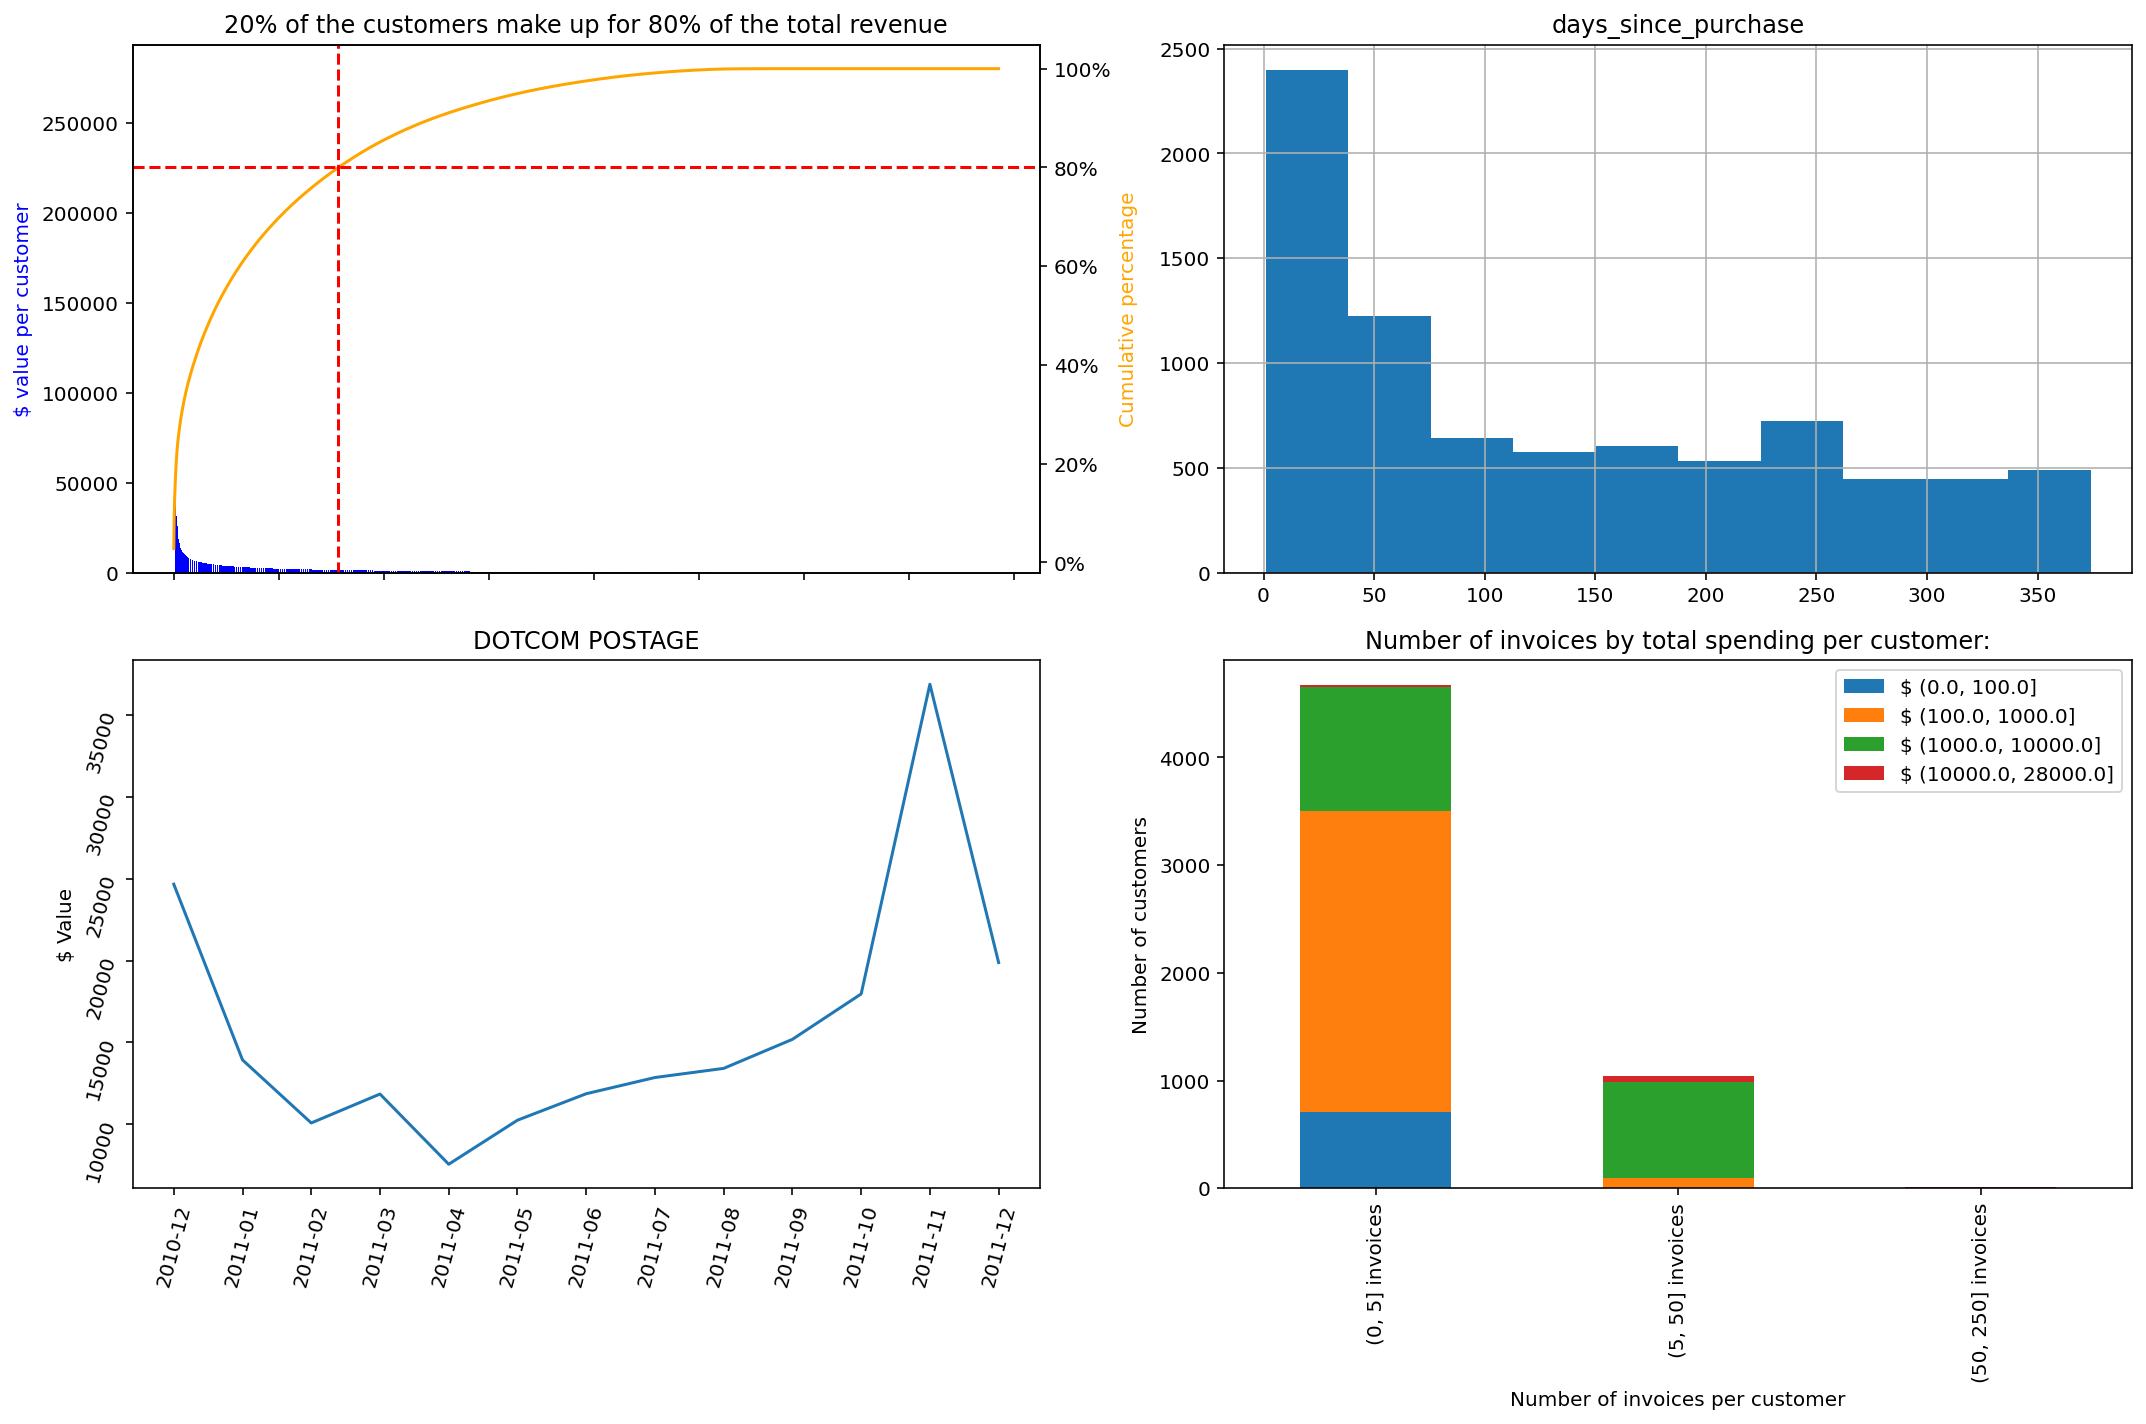

In [26]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].set_title('{}% of the customers make up for 80% of the total revenue'.format(round(value_closest_to_80/len(desc_price)*100)))

ax2 = ax[0,0].twinx()

ax[0,0].bar(desc_price.index,desc_price['TotalPrice'],color='blue');
ax[0,0].set_xlabel('Customers')
ax[0,0].set_ylabel('$ value per customer',color='blue')

ax2.plot(desc_price.index,desc_price['cumulative_pct'],color='orange');
ax2.set_ylabel('Cumulative percentage',color='orange')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2.axhline(y=80, color='r', linestyle='--');
ax2.axvline(x=value_closest_to_80, color='r', linestyle='--');

df4.hist(ax=ax[0,1]);

dfW = dfT[dfT['Description'] == 'DOTCOM POSTAGE']
ax[1,0].plot(dfW['month_year'],dfW['TotalPrice'],label='DOTCOM POSTAGE')
ax[1,0].tick_params(labelrotation=75)
ax[1,0].set_ylabel('$ Value')
ax[1,0].set_title('DOTCOM POSTAGE')

df7.plot.bar(stacked=True, ax=ax[1,1])
ax[1,1].set_xticks([x for x in range(len(df7['countBins']))])
ax[1,1].set_xticklabels(df7['countBins'])

ax[1,1].set_title("Number of invoices by total spending per customer:")
ax[1,1].set_xlabel('Number of invoices per customer')
ax[1,1].set_ylabel('Number of customers');

plt.tight_layout()
plt.savefig('Customers Insights & RFM Analysis.png', dpi=500,transparent=False)
plt.show()